In [1]:
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
import sys, os
from sys import argv
import ROOT
from ROOT import TH2F, TCanvas, TFile
import pandas as pd
from dataclasses import make_dataclass
import multiprocessing as mp

Welcome to JupyROOT 6.22/08


## Part 1, read log and get fit parameters and fit fraction

### Part 1-1, read log
Every bootstrapping sample do 10 random fits.\
Use func `read_logscan` to read the output of these fit results.\
Then use `pd.groupby` and `pd.merge` to get min NLL and its result index for each bootstrapping. \

In [2]:
def read_logscan(logfile):
    """This function is used to read logfiles generated by qnFit/sort.sh.
    To read the nll, file id and fit status into a dataframe.

    Args:
        logfile (_type_): _description_

    Returns:
        dataframe: _description_
    """
    # mass: bootstrapping file; id: fit result index; nll: NLL; status;
    one_log = make_dataclass("one_log", [("mass", float), ("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        mass_temp = l1.split()[0].split("//")[1].split("-")[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[2].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(float(mass_temp), str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [17]:
# Use pd.groupby and pd.merge to get the id of minimum nll for each bootstrapping sample.
df1 = read_logscan("/disk401/lhcb/qinning/b2dpp_farm10/qnFit/bootstrapping/check_log.txt")
df_converged = df1[df1["status"] == "CONVERGED"]
df_groupby = df_converged[["mass","nll"]].groupby(by="mass")["nll"].min()
df_merge = pd.merge(df_groupby,df_converged,how="left",on=["mass","nll"])
df_merge_firstid = df_merge.groupby(by="mass")["id"].min()
df_merge = pd.merge(df_merge_firstid,df_merge,how="left",on=["mass","id"])
print(df_merge.head())
print(df_merge.shape)

   mass    id      nll     status
0   0.0  0002 -11145.9  CONVERGED
1   1.0  0014 -11397.4  CONVERGED
2   2.0  0024 -11205.3  CONVERGED
3   3.0  0031 -11257.6  CONVERGED
4   4.0  0040 -10957.2  CONVERGED
(500, 4)


### Part 1-2, get fit parameters
The `df_merge` could give us the fit parameters file *.func we need.\
Then use the dataframe `df_temp` to load the *.func file.\
`pd.concat` join two dataframe together according to  the same column, which is really useful.

  bootfile    id m0_2900 m0_3130 m0_3189 width_2900 width_3130 width_3189  \
0        0  0002  2.8120  3.2612  2.9790   0.032107    0.22578    0.12089   
0        1  0014  2.8154  3.2518  2.9682   0.026802    0.22121    0.13188   
0        2  0024  2.8134  3.2774  2.9802   0.031579    0.22449    0.11905   
0        3  0031  2.8138  3.2593  2.9719   0.032370    0.18935    0.12430   
0        4  0040  2.8238  3.2518  2.9764   0.030925    0.19329    0.12066   

  width_NR0m  
0     2.2835  
0     1.3082  
0     1.1908  
0     1.0816  
0     2.0800  
(500, 9)
          m0_2900     m0_3130     m0_3189  width_2900  width_3130  width_3189  \
count  500.000000  500.000000  500.000000  500.000000  500.000000  500.000000   
mean     2.815408    3.259735    2.974500    0.030561    0.198991    0.129699   
std      0.005002    0.007422    0.006782    0.005540    0.015485    0.010324   
min      2.805000    3.237800    2.953200    0.014649    0.161550    0.098706   
25%      2.812800    3.254900    

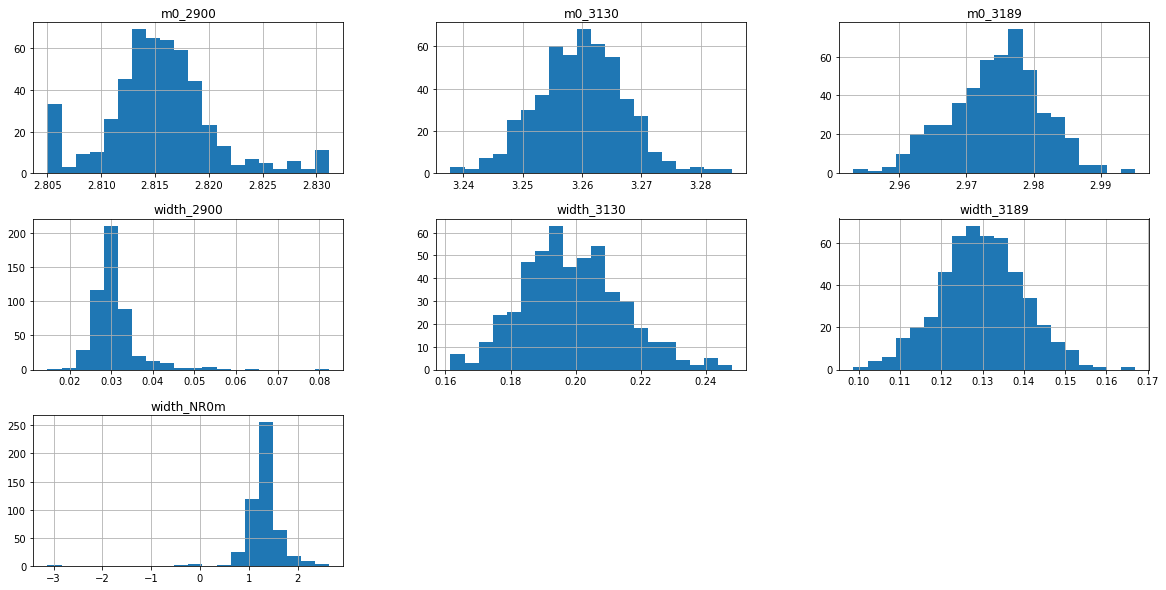

In [18]:
title = ["bootfile","id","m0_2900","m0_3130","m0_3189","width_2900","width_3130","width_3189","width_NR0m"]
df_original = pd.DataFrame(columns=title)
df_original = df_original.append({"bootfile":-999,"id":-999,"m0_2900":-999,"m0_3130":-999,"m0_3189":-999,"width_2900":-999,"width_3130":-999,"width_3189":-999,"width_NR0m":-999},ignore_index=True)
for i in range(0,500):
    if(df_merge[df_merge["mass"]==i].empty):
        continue
    temp_id = df_merge[df_merge["mass"]==i]["id"].values[0]
    temp_filename = "funcs/fit-"+str(i)+"-"+str(temp_id)+".func"
    temp_file = open(temp_filename,"r+")
    dict_temp = {}
    for line1 in temp_file:
        dict_temp[line1.split()[0]] = line1.split()[2]
    dict_temp["bootfile"] = i
    dict_temp["id"] = temp_id
    df_temp = pd.DataFrame(dict_temp,index=[0])
    df_original = pd.concat([df_original,df_temp],join="inner")
df_original = df_original[df_original["bootfile"]>=0]
print(df_original.head())
print(df_original.shape)
df_original.to_csv("fit_result.csv",index=False)
df_result = pd.read_csv("fit_result.csv")
df_result = df_result.drop(["bootfile","id"],axis=1)
print(df_result.describe())
df_result.hist(layout=(3,3),sharex=False,sharey=False,figsize=(20,10),bins=20)
plt.savefig("parameters.pdf")

### Part 1-3, get fit fractions

In [19]:
def read_reverse_order(file_name):
    """Copied from website. Read a file from the end in a quick way

    Args:
        file_name (_type_): _description_

    Yields:
        _type_: _description_
    """
    # Open file for reading in binary mode
    with open(file_name, 'rb') as read_obj:
        # Move the cursor to the end of the file
        read_obj.seek(0, os.SEEK_END)
        # Get the current position of pointer i.e eof
        pointer_location = read_obj.tell()
        # Create a buffer to keep the last read line
        buffer = bytearray()
        # Loop till pointer reaches the top of the file
        while pointer_location >= 0:
            # Move the file pointer to the location pointed by pointer_location
            read_obj.seek(pointer_location)
            # Shift pointer location by -1
            pointer_location = pointer_location -1
            # read that byte / character
            new_byte = read_obj.read(1)
            # If the read byte is new line character then it means one line is read
            if new_byte == b'\n':
                # Fetch the line from buffer and yield it
                yield buffer.decode()[::-1]
                # Reinitialize the byte array to save next line
                buffer = bytearray()
            else:
                # If last read character is not eol then add it in buffer
                buffer.extend(new_byte)
        # As file is read completely, if there is still data in buffer, then its the first line.
        if len(buffer) > 0:
            # Yield the first line too
            yield buffer.decode()[::-1]

def read_FF(logfile_name):
    """Use function read_reverse_order to read the logfile from the end.
    Because the Fit Fractions is at the end of each log file.

    Args:
        logfile_name (_type_): _description_
    """
    i = 0
    temp_dict = {}
    for line in read_reverse_order(logfile_name):
        if(i>18):
            break
        if(i>5):
            #print({line.split()[0]:line.split()[1]})
            temp_dict[line.split()[0]] = line.split()[1]
            #print(line.split()[1])
            #print(line.split()[0])
        i = i+1
#    temp_dict["bootfile"] = logfile_name
    return temp_dict

In [20]:
df_FF = pd.DataFrame(read_FF("test.log"),index=[0])
df_original = pd.read_csv("fit_result.csv")
df_original = df_original[["bootfile","id"]]
arr_original = df_original.values.tolist()
for i in range(len(arr_original)):
    temp_filename = "log_bootstrapping/fit-"+str(arr_original[i][0])+"-"+str(arr_original[i][1]).zfill(4)+".log"
    df_FF = df_FF.append(read_FF(temp_filename),ignore_index=True)
df_FF = df_FF.drop([0])
print(df_FF.head())
print(df_FF.shape)
df_FF.to_csv("FF_result.csv",index=False)
df_FF_new = pd.read_csv("FF_result.csv") # export to csv and read it again can show the correct df.describe() result. so ridiculous.
df_FF_new.describe()

    Total X_f2_2150 X_f2_1950 X_rho_2150 X_Fwave X_NR0m Y_L_2860 Y_L_2880  \
1  118.80      5.71      3.33      13.69   47.47   2.59     5.87     0.48   
2  133.29      5.76      4.32      11.82   51.87   3.70     5.04     0.63   
3  136.33      5.42      5.98       9.37   60.43   1.84     3.77     0.57   
4  126.48      6.08      4.58      10.81   55.68   1.89     6.81     0.47   
5  115.34      4.76      5.70       9.65   44.77   2.91     2.72     0.32   

  Y_L_2765 Y_L_2900 Y_L_3130 Y_L_3189       ======Fit  
1     9.32     3.29    10.82    16.24  Fraction======  
2     9.44     5.40    11.27    24.03  Fraction======  
3    16.37     4.58    12.14    15.88  Fraction======  
4     5.75     4.94    10.30    19.16  Fraction======  
5    17.41     4.22    10.46    12.42  Fraction======  
(500, 13)


Total  X_f2_2150   X_f2_1950  X_rho_2150     X_Fwave      X_NR0m  \
count  500.000000  500.00000  500.000000  500.000000  500.000000  500.000000   
mean   127.872400    5.66092    4.411600   11.431580   54.494560    2.740400   
std      7.564724    0.66728    0.965671    1.735678    6.408294    1.410241   
min    105.110000    3.89000    1.720000    6.240000   31.140000    0.000000   
25%    123.077500    5.22000    3.740000   10.400000   51.052500    1.687500   
50%    130.975000    5.67000    4.430000   11.340000   55.835000    2.635000   
75%    133.302500    6.12250    5.100000   12.565000   59.270000    3.617500   
max    141.100000    7.95000    8.000000   17.920000   66.060000    9.790000   

         Y_L_2860    Y_L_2880   Y_L_2765    Y_L_2900    Y_L_3130   Y_L_3189  
count  500.000000  500.000000  500.00000  500.000000  500.000000  500.00000  
mean     5.011120    0.371100   10.32098    4.783060   10.469200   18.17868  
std      1.000793    0.106589    5.94140    1.129746    1.006667    3.74475  
min      2.240000    0.110000    1.70000    1.150000    7.980000    6.77000  
25%      4.337500    0.290000    6.40500    4.015000    9.797500   15.91750  
50%      5.010000    0.370000    9.19500    4.950000   10.390000   18.84500  
75%      5.672500    0.440000   12.52750    5.540000   11.020000   20.90000  
max      8.230000    0.730000   46.76000    9.410000   14.840000   27.15000

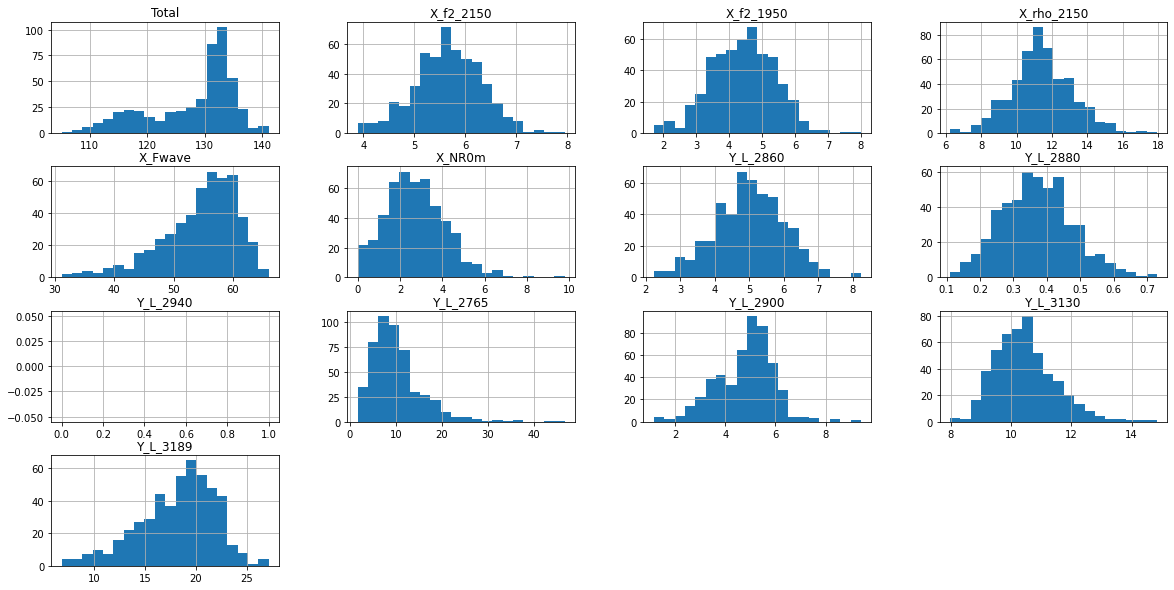

In [9]:
df_FF_new.hist(layout=(4,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
plt.savefig("FitFraction.pdf")

## Part 2, calculate the asymmetrical error for fit fraction and parameters

In [21]:
def cal_asym_std(df_input, mean_input):
    if df_input.empty:
        return -999
    else:
        return sqrt(pow(df_input - mean_input,2).sum()/df_input.size)

def read_logfile(logfile):
    one_log = make_dataclass("one_log", [("id", str), ("nll",float), ("status", str)])
    df1 = pd.DataFrame()
    f1 = open(logfile,"r+")
    for l1 in f1:
        nll_temp = l1.split()[1]
        id_temp = l1.split()[0].split("//")[1].split("-")[1].split(".")[0]
        status_temp = l1.split()[3]
        df1 = df1.append([one_log(str(id_temp), float(nll_temp), str(status_temp))], ignore_index=True)
    return df1

In [22]:
df_FF = pd.read_csv("FF_result.csv")
df_FF.describe()

#dict_FF_model0 = {"X_f2_2150":5.12, "X_rho_2150":9.36, "X_f2_1950":3.63, "X_NR0m":2.41, "X_Fwave":49.77, "Y_L_2765":8.51, "Y_L_2940":0.14, "Y_L_2860":4.07, "Y_L_2880":0.28, "Y_L_2900":4.22, "Y_L_3130":12.26, "Y_L_3189":13.40}
dict_FF_model0 = {"X_f2_2150":5.73, "X_rho_2150":11.54, "X_f2_1950":4.36, "X_NR0m":3.12, "X_Fwave":58.84, "Y_L_2765":5.98, "Y_L_2860":5.19, "Y_L_2880":0.34, "Y_L_2900":5.52, "Y_L_3130":10.39, "Y_L_3189":21.13}

temp_name = "X_f2_2150"
df_FF_temp = df_FF[df_FF[temp_name] > dict_FF_model0[temp_name]]

list_up = []
list_lo = []
for key,value in dict_FF_model0.items():
    df_FF_up = df_FF[ df_FF[key] > value ][key]
    df_FF_lo = df_FF[ df_FF[key] < value ][key]
    list_up.append(cal_asym_std(df_FF_up, value))
    list_lo.append(cal_asym_std(df_FF_lo, value))

i=0
for key,value in dict_FF_model0.items():
    temp_FF = "$" + "{:.2f}".format(value) + "^{+" + "{:.2f}".format(list_up[i]) +"}" + "_{-" + "{:.2f}".format(list_lo[i]) +"}$ "
    line = "{:<15} & {:<30} \\\\".format(key, temp_FF)
    print(line)
    i = i+1

X_f2_2150       & $5.73^{+0.64}_{-0.70}$         \\
X_rho_2150      & $11.54^{+1.80}_{-1.69}$        \\
X_f2_1950       & $4.36^{+0.97}_{-0.96}$         \\
X_NR0m          & $3.12^{+1.44}_{-1.47}$         \\
X_Fwave         & $58.84^{+2.70}_{-8.96}$        \\
Y_L_2765        & $5.98^{+8.16}_{-1.96}$         \\
Y_L_2860        & $5.19^{+0.91}_{-1.10}$         \\
Y_L_2880        & $0.34^{+0.12}_{-0.09}$         \\
Y_L_2900        & $5.52^{+0.80}_{-1.49}$         \\
Y_L_3130        & $10.39^{+1.15}_{-0.85}$        \\
Y_L_3189        & $21.13^{+1.94}_{-5.31}$        \\


In [27]:
dict_FitParameters_model0 = {"m0_2900":2.816,"m0_3130":3.259,"m0_3189":2.977,"width_2900":0.029,"width_3130":0.201,"width_3189":0.139}
list_up_FP = []
list_lo_FP = []
for key,value in dict_FitParameters_model0.items():
    df_result_up = df_result[ df_result[key] > value ][key]
    df_result_lo = df_result[ df_result[key] < value ][key]
    list_up_FP.append(cal_asym_std(df_result_up, value))
    list_lo_FP.append(cal_asym_std(df_result_lo, value))
i=0
for key,value in dict_FitParameters_model0.items():
    temp_FF = "$" + str(value) + "^{+" + "{:.3f}".format(list_up_FP[i]) +"}" + "_{-" + "{:.3f}".format(list_lo_FP[i]) +"}$ "
    line = "{:<15} & {:<30} &".format(key, temp_FF)
    print(line)
    i = i+1

m0_2900         & $2.816^{+0.005}_{-0.005}$      &
m0_3130         & $3.259^{+0.008}_{-0.007}$      &
m0_3189         & $2.977^{+0.005}_{-0.008}$      &
width_2900      & $0.029^{+0.007}_{-0.003}$      &
width_3130      & $0.201^{+0.016}_{-0.016}$      &
width_3189      & $0.139^{+0.008}_{-0.015}$      &


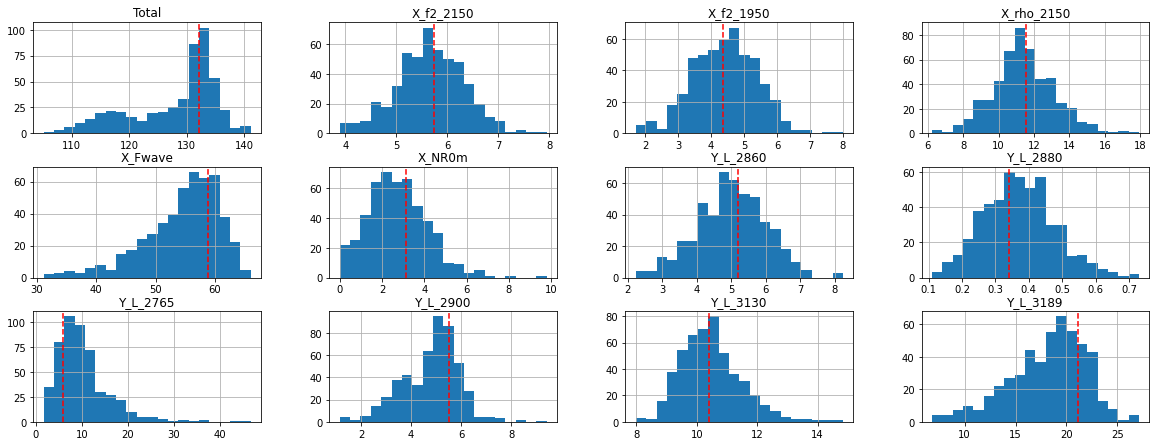

In [25]:
plots_FF=df_FF_new.hist(layout=(4,4),sharex=False,sharey=False,figsize=(20,10),bins=20)
for i in range(len(plots_FF)):
    for ax in plots_FF[i]:
        if ax.get_title() == "Total":
            temp_mean = 132.12
        elif ax.get_title() == "":
            continue
        else:
            temp_mean = dict_FF_model0[ax.get_title()]
        ax.axvline(x=temp_mean,color="red",linestyle="--")

## Part 4, UEFA Champions League

This part aims to calculate the probability of UEFA draw for Round-16

### Part 4-1 A simple MC simulation procedure
This simple MC procedure just takes the "not same group" and "not same league" principals into account.\
Without considering the real procedure in UEFA draw, this simple MC may have bias with the reality.

In [12]:
def compare_Group(arr_1,arr_2):
    if arr_1[1] == arr_2[1]:
        return False
    else:
        return True
def compare_League(arr_1,arr_2):
    if arr_1[3] == arr_2[3]:
        return False
    else:
        return True


In [13]:
df_all_team = pd.read_csv("EuroChampion.csv")
bool_1 = True
Champion_16 = np.zeros([8,8])

arr_1_original = df_all_team[df_all_team["Rank"]==1].values
arr_2_original = df_all_team[df_all_team["Rank"]==2].values

times = 0
total_times = 100000
success_times = 0
print("Start to run the simulation...")
while times < total_times:
    Champion_16_temp = np.zeros([8,8])
    times += 1
    arr_1 = arr_1_original
    arr_2 = arr_2_original
    np.random.shuffle(arr_1)
    np.random.shuffle(arr_2)
    for j in range(8):
        for i in range(len(arr_2)):
            bool1 = compare_Group(arr_1[0],arr_2[i]) and compare_League(arr_1[0],arr_2[i])
            if bool1:
                Champion_16_temp[arr_2[i][4]-1][arr_1[0][4]-1] += 1
                arr_1 = np.delete(arr_1,0,0)
                arr_2 = np.delete(arr_2,i,0)
                break
    bool_empty = not(len(arr_1) + len(arr_2))
    if bool_empty:
        success_times += 1
        Champion_16 += Champion_16_temp
print("Total simulation: ",total_times,"; Success simulation: ",success_times)
print("Run the next cell to see the result.")
    

Start to run the simulation...


KeyboardInterrupt: 

In [ ]:
print([df_all_team[df_all_team["Rank"]==1].values[i][0] for i in range(8)])
print([df_all_team[df_all_team["Rank"]==2].values[i][0] for i in range(8)])
np.set_printoptions(precision=5)
print(Champion_16/success_times)
print(success_times)

['Napoli', 'Porto', 'Bayern', 'Tottenham', 'Chelsea', 'Real Madrid', 'Manchester City', 'Benfica']
['Liverpool', 'Brugge', 'Inter Milan', 'Frankfurt', 'AC Milan', 'RB Leipzig', 'Dortmund', 'PSG']
[[0.      0.20719 0.37337 0.      0.      0.21037 0.      0.20907]
 [0.17073 0.      0.19119 0.14148 0.13952 0.10892 0.13936 0.10881]
 [0.      0.14443 0.      0.18802 0.18885 0.14921 0.18806 0.14142]
 [0.22263 0.13655 0.      0.      0.17935 0.14229 0.18257 0.13662]
 [0.      0.13486 0.24208 0.1746  0.      0.1401  0.17329 0.13507]
 [0.21292 0.13086 0.      0.17474 0.17485 0.      0.17505 0.13159]
 [0.22352 0.13914 0.      0.18229 0.17934 0.13829 0.      0.13743]
 [0.17021 0.10697 0.19335 0.13887 0.13809 0.11083 0.14167 0.     ]]
71770


### Part 4-2, simulation from reality.

#### Basic steps
1. 先抽排名第二的队
2. 排除不可能的队
3. 再抽可能的排名第一的队

In [ ]:
def com_df_group(df_1,df_2):
    if df_1["Group"] == df_2["Group"]:
        return False
    else:
        return True
def com_df_league(df_1,df_2):
    if df_1["League"] == df_2["League"]:
        return False
    else:
        return True

def how_many_match(df_1,df_2):
    if len(df_1)!=len(df_2):
        print("The length of two dataframes is not equal!")
        return -999
    list_match = np.zeros((2,len(df_1)))
    for i in range(len(df_1)):
        for j in range(len(df_2)):
            if com_df_group(df_1.iloc[i],df_2.iloc[j]) and com_df_league(df_1.iloc[i],df_2.iloc[j]):
                list_match[0][i] += 1
    for i in range(len(df_2)):
        for j in range(len(df_1)):
            if com_df_group(df_2.iloc[i],df_1.iloc[j]) and com_df_league(df_2.iloc[i],df_1.iloc[j]):
                list_match[1][i] += 1
    return list_match
def pick_specific(df_rank1, df_rank2, which_to_pick:int, pick_number:int,Champion_16_temp):
    if which_to_pick == 1:
        df_temp1 = df_rank1.copy()
        df_rank1 = df_rank2
        df_rank2 = df_temp1
    df_rank2_picked = df_rank2.iloc[pick_number]
    df_rank1_todrop = df_rank1[(df_rank1["Group"]==df_rank2_picked["Group"]) | (df_rank1["League"]==df_rank2_picked["League"])]  # type: ignore
    df_rank1_inpool = df_rank1.drop(df_rank1_todrop.index).reset_index(drop=True)
    df_rank1_picked = df_rank1_inpool.iloc[np.random.randint(0,len(df_rank1_inpool))]
    df_rank1 = df_rank1.drop(df_rank1.loc[df_rank1["Name"]==df_rank1_picked["Name"]].index)
    df_rank2 = df_rank2.drop(df_rank2.loc[df_rank2["Name"]==df_rank2_picked["Name"]].index)
    if which_to_pick == 1:
        Champion_16_temp[df_rank1_picked["TH2F"]-1][df_rank2_picked["TH2F"]-1] += 1  
        return df_rank2,df_rank1,Champion_16_temp
    else:
        Champion_16_temp[df_rank2_picked["TH2F"]-1][df_rank1_picked["TH2F"]-1] += 1  
        return df_rank1,df_rank2,Champion_16_temp

def one_round(df_rank1,df_rank2,which_to_pick,Champion_16_temp):
    pick_number = np.random.randint(0,len(df_rank2))
    df_rank1,df_rank2,Champion_16_temp = pick_specific(df_rank1,df_rank2,which_to_pick,pick_number,Champion_16_temp)
    return df_rank1,df_rank2,Champion_16_temp


#### Single-threaded
Slow, but easier to read and test.\
For quicker MC use [Multi-threaded](#multi-threaded).

In [ ]:
df_all_team = pd.read_csv("EuroChampion.csv")
df_rank1_original = df_all_team[df_all_team["Rank"]==1]
df_rank2_original = df_all_team[df_all_team["Rank"]==2]
df_rank1 = df_all_team[df_all_team["Rank"]==1]
df_rank2 = df_all_team[df_all_team["Rank"]==2]
Champion_16 = np.zeros([8,8])

MC_times = 0
fail_times = 0
total_times = 100
while MC_times < total_times:
    if MC_times%10 == 0:
        print(MC_times)
    df_rank1 = df_all_team[df_all_team["Rank"]==1]
    df_rank2 = df_all_team[df_all_team["Rank"]==2]
    for i in range(8):
        Champion_16_temp = np.zeros([8,8])
        if len(df_rank2)>5:
            df_rank1,df_rank2,Champion_16_temp = one_round(df_rank1,df_rank2,2,Champion_16_temp)
            Champion_16 += Champion_16_temp
        else:
            list_match = how_many_match(df_rank1,df_rank2)
            rank1_match = np.prod([item-1 for item in list_match[0]])
            rank2_match = np.prod([item-1 for item in list_match[1]])
            #if MC_times>30:
            #    print(MC_times)
            #    print(list_match)
            if len(list_match[0]) == 3:
                if np.sum(list_match[0]) == 4:
                    if(np.array(list_match[0]) == 2).any():
                        fail_times += 1
                        break
                elif np.sum(list_match[0]) == 5:
                    if(np.array(list_match[0]) == 3).any():
                        fail_times += 1
                        break
            if rank2_match and rank1_match:
                df_rank1,df_rank2,Champion_16_temp = one_round(df_rank1,df_rank2,2,Champion_16_temp)
                Champion_16 += Champion_16_temp
            #elif not rank2_match and rank1_match:
            elif not rank2_match:
                for j in range(len(list_match[1])):
                    if list_match[1][j]>1:
                        continue
                    elif list_match[1][j]==1:
                        df_rank1,df_rank2,Champion_16_temp = pick_specific(df_rank1,df_rank2,2,j,Champion_16_temp)
                        Champion_16 += Champion_16_temp
                        break
                    else:
                        print("error1")
            #elif not rank1_match and rank2_match:
            elif not rank1_match:
                for j in range(len(list_match[0])):
                    if list_match[0][j]>1:
                        continue
                    elif list_match[0][j]==1:
                        df_rank1,df_rank2,Champion_16_temp = pick_specific(df_rank1,df_rank2,1,j,Champion_16_temp)
                        Champion_16 += Champion_16_temp
                        break
                    else:
                        print("error2")
            else:
                print("error3")
    MC_times += 1
print(Champion_16)


0
10
20
30
40
50
60
70
80
90
[[ 0. 20. 42.  0.  0. 14.  0. 22.]
 [20.  0. 14. 11. 17. 16. 14.  8.]
 [ 0. 16.  0. 20. 17. 14. 22. 11.]
 [24. 13.  0.  0. 20. 14.  7. 21.]
 [ 0. 15. 25. 13.  0. 14. 17. 15.]
 [22.  8.  0. 17. 15.  0. 25. 12.]
 [17. 16.  0. 20. 18. 19.  0.  9.]
 [17. 12. 18. 18. 12.  9. 14.  0.]]


#### Multi-threaded
Use mp.applyasync and mp.manager for multi processing.\
The right way to output into a file in a multi-threaded code see [this link](https://stackoverflow.com/questions/13446445/python-multiprocessing-safely-writing-to-a-file)

In [ ]:
fn = "./Champion16.csv"
def run_times_for_multiprocessing(q):
    np.random.seed(os.getpid())
    df_all_team = pd.read_csv("EuroChampion.csv")
    df_rank1_original = df_all_team[df_all_team["Rank"]==1]
    df_rank2_original = df_all_team[df_all_team["Rank"]==2]
    df_rank1 = df_all_team[df_all_team["Rank"]==1]
    df_rank2 = df_all_team[df_all_team["Rank"]==2]
    Champion_16 = np.zeros([8,8])

    MC_times = 0
    fail_times = 0
    total_times = 1000
    while MC_times < total_times:
        #if MC_times%100 == 0:
        #    print(MC_times)
        df_rank1 = df_all_team[df_all_team["Rank"]==1]
        df_rank2 = df_all_team[df_all_team["Rank"]==2]
        for i in range(8):
            Champion_16_temp = np.zeros([8,8])
            if len(df_rank2)>5:
                df_rank1,df_rank2,Champion_16_temp = one_round(df_rank1,df_rank2,2,Champion_16_temp)
                Champion_16 += Champion_16_temp
            else:
                list_match = how_many_match(df_rank1,df_rank2)
                rank1_match = np.prod([item-1 for item in list_match[0]])
                rank2_match = np.prod([item-1 for item in list_match[1]])
                if len(list_match[0]) == 3:
                    if np.sum(list_match[0]) == 4:
                        if(np.array(list_match[0]) == 2).any():
                            fail_times += 1
                            break
                    elif np.sum(list_match[0]) == 5:
                        if(np.array(list_match[0]) == 3).any():
                            fail_times += 1
                            break
                if rank2_match and rank1_match:
                    df_rank1,df_rank2,Champion_16_temp = one_round(df_rank1,df_rank2,2,Champion_16_temp)
                    Champion_16 += Champion_16_temp
                #elif not rank2_match and rank1_match:
                elif not rank2_match:
                    for j in range(len(list_match[1])):
                        if list_match[1][j]>1:
                            continue
                        elif list_match[1][j]==1:
                            df_rank1,df_rank2,Champion_16_temp = pick_specific(df_rank1,df_rank2,2,j,Champion_16_temp)
                            Champion_16 += Champion_16_temp
                            break
                        else:
                            print("error1")
                elif not rank1_match:
                    for j in range(len(list_match[0])):
                        if list_match[0][j]>1:
                            continue
                        elif list_match[0][j]==1:
                            df_rank1,df_rank2,Champion_16_temp = pick_specific(df_rank1,df_rank2,1,j,Champion_16_temp)
                            Champion_16 += Champion_16_temp
                            break
                        else:
                            print("error2")
                else:
                    print("error3")
        MC_times += 1
    #print(Champion_16)
    text=""
    for i in range(len(Champion_16[0])):
        for j in range(len(Champion_16[0])):
#            if j==len(Champion_16[0])-1 and i==len(Champion_16[0])-1:
#                text += str(Champion_16[i][j])
#            else:
            text += str(int(Champion_16[i][j])) + ","
    text += str(fail_times)

    with open(fn, "rb") as f:
        size = len(f.read())
    res = "Process-{}-{}".format(os.getpid(), size)
    q.put(text)
    return res
 
def listener(q):
    '''listens for messages on the q, writes to file. '''

    with open(fn, 'w') as f:
        while 1:
            m = q.get()
            if m == 'kill':
                f.write('killed')
                break
            f.write(str(m) + '\n')
            f.flush()

if __name__ == "__main__":
    manager = mp.Manager()
    q = manager.Queue()
    pool = mp.Pool(processes=150)
    watcher = pool.apply_async(listener, (q,))

    jobs = []
    for i in range(100):
        job = pool.apply_async(run_times_for_multiprocessing, (q,))
        jobs.append(job)

In [ ]:
np.set_printoptions(precision=4)
df_Champion16 = pd.read_csv("Champion16.csv",header=None)
df_Champion16.loc[:,'Row_Total']= df_Champion16.sum(numeric_only=True, axis=1)
df_Champion16.loc['Column_Total']= df_Champion16.sum(numeric_only=True, axis=0)
print(df_Champion16.tail())
print(df_Champion16[20]["Column_Total"])
Champion_16_multi = np.zeros([8,8])
column_number = 0
for i in range(8):
    for j in range(8):
        Champion_16_multi[i][j] = df_Champion16[column_number]["Column_Total"]
        column_number += 1
fail_times = df_Champion16[64]["Column_Total"]
total_times = (df_Champion16[64]["Column_Total"]*2 + df_Champion16["Row_Total"]["Column_Total"])/8
print(total_times)
print(Champion_16_multi/(total_times-fail_times))
print((Champion_16_multi/(total_times-fail_times))[0][2])

              0      1      2  3  4      5  6      7      8  9  ...     56  \
96            0    201    347  0  0    237  0    210    173  0  ...    179   
97            0    203    380  0  0    200  0    208    168  0  ...    181   
98            0    215    378  0  0    200  0    195    182  0  ...    175   
99            0    203    340  0  0    237  0    205    178  0  ...    182   
Column_Total  0  20810  36263  0  0  21221  0  20503  17124  0  ...  17067   

                 57     58     59     60     61     62  63    64  Row_Total  
96              106    196    147    144    104    124   0     6       7988  
97              118    179    138    138    108    138   0    12       7976  
98              115    183    129    138    116    144   0    15       7970  
99              122    203    125    122    109    137   0    16       7968  
Column_Total  10753  19560  13822  13920  10998  13827   0  1465     797070  

[5 rows x 66 columns]
19093
100000.0
[[0.     0.2112 0.368  0.